<a href="https://colab.research.google.com/github/SizhuangHe/FL-REU/blob/main/FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [233]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils
from torchsummary import summary

# Check assigned GPU
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Some Hyperparameters

In [234]:
input_size = 4
num_hidden_neuron = 100
output_size = 3

# Load DataSet

## Prepare the Data

In [235]:
df = pd.read_csv("Iris.csv")

le=LabelEncoder()
df['Species']=le.fit_transform(df['Species'])

label=df['Species'].values

scaler=StandardScaler()
df = df.drop('Species',axis=1)
df = df.drop('Id', axis=1)
scaled_df=scaler.fit_transform(df)

feature=scaled_df.astype(np.float32)




In [236]:
feature_train,feature_test,label_train, label_test=train_test_split(feature, label,test_size=0.20,random_state=42)

In [237]:
class IrisData(Dataset):
  def __init__(self, feature_train, label_train):
    self.feature = feature_train
    self.label = label_train

  def __len__(self):
    return len(self.label) 

  def __getitem__(self, idx):
    return self.feature[idx], self.label[idx]   

In [238]:
dataset_train = IrisData(feature_train, label_train)
dataset_test = IrisData(feature_test, label_test)

In [239]:
classes_test = [0, 1, 2, 3] #don't know how to do here

# Partition the Data

In [240]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [259]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """

  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.label

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
      
  
  return client_dict




In [242]:
def client_dict_train_val_split(client_dict_in, validation_ratio):
  """
  Split each client data randomly to two parts: training data and validation data

  param:
    - client_dict_in (python dictionary): the client dictionary
    - validation_ratio (double): the proportion of client data to be spitted into validation data

  returns:
    - dictionary of indices for each client's training and validation data  
  """
  client_dict_out = {}


  for client in client_dict_in:
    num_total_data = len(client_dict_in[client])
    num_val_data = int(num_total_data * validation_ratio)
    val_set = set(np.random.choice(np.array(list(client_dict_in[client])), num_val_data, replace=False))
    train_set = client_dict_in[client] - val_set
    client_dict_out[client]={}
    client_dict_out[client]["train"] = train_set
    client_dict_out[client]["validation"] = val_set
    
  return client_dict_out  

# Models

In [243]:
class IRIS_NN(nn.Module):
  def __init__(self, input_size, num_hidden_neurons, output_size):
    super(IRIS_NN, self).__init__()

    self.l1 = nn.Linear(input_size, num_hidden_neurons)
    self.l2 = nn.Linear(num_hidden_neurons, num_hidden_neurons)
    self.l3 = nn.Linear(num_hidden_neurons, output_size)

  def forward(self, x):
    x = torch.flatten(x,1)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    out = self.l3(x)
    return out

# Client Training


In [244]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []

    

    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

# Server Training

In [245]:
def training(model, rounds, batch_size, lr, ds, data_dict, C, K, E, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []
  
  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k]["train"])
      weights, loss = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    # validation
    model.eval()
    criterion = nn.CrossEntropyLoss()
    print("-> Validation\n")
    for k in S_t:
      print(f"Validation on Client {k}")
      validate(model, dataset_train, iid_dict[k]["validation"], criterion, 3, classes_test)
    


  end = time.time()
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model

In [246]:
def validate(model, dataset, val_idx, criterion,num_classes, classes):
  batch_size = len(val_idx)
  val_loader = DataLoader(CustomDataset(dataset, val_idx), batch_size=len(val_idx), shuffle=True)
  test(model, dataset, batch_size, criterion, num_classes, classes, val_loader, "Validation")
  


# Test

In [247]:
def test(model, dataset, bs, criterion, num_classes, classes, loader, mode):
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  for data, labels in loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)


    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())


    #test accuracy for each object class
    for i in range(len(data)):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(loader.dataset)
  
  print(mode, "Loss: {:.6f}\n".format(test_loss))


  # print test accuracy
  for i in range(num_classes):
    if total_class[i]>0:
      print(mode, 'Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i]))) 

    else:
      print(mode, 'Accuracy of %5s: N/A (no '% (classes[i]), mode, ' examples)' )
      
  print('\nFinal ', mode, ' Accuracy: {:.3f} ({}/{})\n'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))
  

In [248]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  test_loader = DataLoader(dataset, batch_size=bs)
  
  model.eval()
  test(model, dataset, bs, criterion, num_classes, classes, test_loader, "Test")

# IID Case

## Training

Round: 1... 	Average Loss: 1.057
-> Validation

Validation on Client 2
Validation Loss: 0.907939

Validation Accuracy of     0: 100% ( 7/ 7)
Validation Accuracy of     1: N/A (no  Validation  examples)
Validation Accuracy of     2: 100% ( 1/ 1)

Final  Validation  Accuracy: 100.000 (8.0/8.0)

Validation on Client 0
Validation Loss: 1.053609

Validation Accuracy of     0: 100% ( 1/ 1)
Validation Accuracy of     1: 50% ( 2/ 4)
Validation Accuracy of     2:  0% ( 0/ 3)

Final  Validation  Accuracy: 37.500 (3.0/8.0)

Validation on Client 1
Validation Loss: 0.966334

Validation Accuracy of     0: 100% ( 2/ 2)
Validation Accuracy of     1: 100% ( 1/ 1)
Validation Accuracy of     2: 100% ( 5/ 5)

Final  Validation  Accuracy: 100.000 (8.0/8.0)

Round: 2... 	Average Loss: 0.919
-> Validation

Validation on Client 0
Validation Loss: 0.976477

Validation Accuracy of     0: 100% ( 1/ 1)
Validation Accuracy of     1: 50% ( 2/ 4)
Validation Accuracy of     2: 33% ( 1/ 3)

Final  Validation  Accuracy

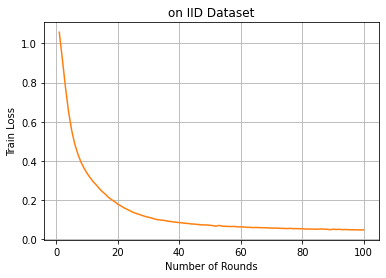

In [249]:
# number of training rounds
rounds = 100
# client fraction
C = 1
# number of clients
K = 3
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
client_dict = iid_partition(dataset_train, 3)
iid_dict = client_dict_train_val_split(client_dict_in=client_dict, validation_ratio=0.2)
# load model
model_iid = IRIS_NN(input_size, num_hidden_neuron, output_size)

if torch.cuda.is_available():
  model_iid.cuda()

model_iid_trained = training(model_iid, rounds, batch_size, lr, dataset_train, iid_dict, C, K, E, "on IID Dataset", "orange")

## Testing

In [250]:
criterion = nn.CrossEntropyLoss()
testing(model_iid_trained, dataset_test, 10, criterion, 3, classes_test)


Test Loss: 0.050391

Test Accuracy of     0: 100% (10/10)
Test Accuracy of     1: 100% ( 9/ 9)
Test Accuracy of     2: 100% (11/11)

Final  Test  Accuracy: 100.000 (30.0/30.0)



# Non IID training

In [261]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 3
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
# TODO: change client_dict's elements to sets
client_dict = non_iid_partition(dataset_train, 3, 12, 10, 4)
print(client_dict)

#non_iid_dict = client_dict_train_val_split(client_dict_in=client_dict, validation_ratio=0.2)

# load model
model_non_iid = IRIS_NN(input_size, num_hidden_neuron, output_size)

if torch.cuda.is_available():
  model_non_iid.cuda()

#model_non_iid_trained = training(model_non_iid, rounds, batch_size, lr, dataset_train, non_iid_dict, C, K, E, "on non IID Dataset", "orange")

{0: array([  0,  23,  70,  91,  26,  27,  28,  58,  48,  31,  32,  33,  71,
        35,  72,  84,  38,  75,  67,  41, 112, 106,  97, 109, 101, 107,
        61,  21,  56,  63,  12,  44,  11,  20,  47,   2,  49,  54,  53,
        45]), 1: array([ 64,  50,  68,  69,  46,  74,  76,  96,  77,  42,  65,  73,  62,
        90,  80,  82,  86,  88,  89,  92,  93,  95,  99, 105, 108, 110,
       111, 115,  79,  60,  59,  29,  22,  25, 118,  18,  34,  36,  39,
        15]), 2: array([ 51,   9,  55,  13,  14,  66, 104, 102,  52,  78,   6,  10,  19,
       116,   5, 100,  17, 103, 113,  16,  94,  98,   1, 117,   3,   4,
        57, 114,   7,   8,  40,  81,  83,  37,  85,  87,  30,  24,  43,
       119])}


## Test

In [ ]:
criterion = nn.CrossEntropyLoss()
testing(model_non_iid_trained, dataset_test, 10, criterion, 3, classes_test)